In [79]:
# Import modules
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import Affine
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import box
from shapely.geometry import Polygon, Point
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import os

import import_ipynb

In [80]:
import svr

We will utilize shapefiles of San Francisco Bay Area county boundaries and rainfall "values" that were "sampled" in the Bay Area. We will load in the data and reproject the data (click the + below to show code cell).


```{Note} It is critical to use a 'projected' coordinate system when doing interpolation. If you keep your data in geographic lat lon distances will vary significantly as you move up and down in latitude... since interpolation depends on distance as a way of establishing relationships this would be a problem... a big one. 
```

In [81]:
# Load data

# County boundaries
# Source: https://opendata.mtc.ca.gov/datasets/san-francisco-bay-region-counties-clipped?geometry=-125.590%2C37.123%2C-119.152%2C38.640
rainfall_path = os.getcwd() + '\Dados vetoriais\Pontos amostrais_Piracicaba\Dados_227pts_original_06_03_2021.shp'
counties_path = os.getcwd()+ '\Dados vetoriais\Piracicaba\Perimetro_Piracicaba.shp'

counties = gpd.read_file(counties_path)

# Rainfall measurement "locations"
# Source: https://earthworks.stanford.edu/catalog/stanford-td754wr4701
# Modified by author by clipping raster to San Francisco Bay Area, generating random points, and extracting raster values (0-255) to the points
rainfall = gpd.read_file(rainfall_path)

proj = rainfall.crs
counties = counties.to_crs(proj)
rainfall = rainfall.to_crs(proj)

rainfall["VALUE"] = rainfall.Argila

Next, we'll prepare the data for geoprocessing (click the + below to show code cell).

In [82]:
# Get X and Y coordinates of rainfall points
x_rain = rainfall["geometry"].x
y_rain = rainfall["geometry"].y

# Create list of XY coordinate pairs
coords_rain = [list(xy) for xy in zip(x_rain, y_rain)]

# Get extent of counties feature
min_x_counties, min_y_counties, max_x_counties, max_y_counties = counties.total_bounds

# Get list of rainfall "values"
value_rain = list(rainfall["VALUE"])

# Create a copy of counties dataset
counties_dissolved = counties.copy()

# Add a field with constant value of 1
counties_dissolved["constant"] = 1

# Dissolve all counties to create one polygon
counties_dissolved = counties_dissolved.dissolve(by = "constant").reset_index(drop = True)

We will also define a function for exporting rasters.

In [83]:
def export_kde_raster(Z, XX, YY, min_x, max_x, min_y, max_y, proj, filename):
    '''Export and save a kernel density raster.'''

    # Get resolution
    xres = (max_x - min_x) / len(XX)
    yres = (max_y - min_y) / len(YY)

    # Set transform
    transform = Affine.translation(min_x - xres / 2, min_y - yres / 2) * Affine.scale(xres, yres)

    # Export array as raster
    with rasterio.open(
            filename,
            mode = "w",
            driver = "GTiff",
            height = Z.shape[0],
            width = Z.shape[1],
            count = 1,
            dtype = Z.dtype,
            crs = proj,
            transform = transform,
    ) as new_dataset:
            new_dataset.write(Z, 1)

With any model used for prediction, it is important to assess the model fit for unobserved locations (or the accuracy of the values predicted by the model in relation to their actual values). Thus, in order to assess the fit, we break our data into two portions, a "training" data set used to train the model, and a "testing" set that remains "unseen" by the model but can be used to assess model performance. Effectively, we can use this "unseen" testing subset to validate the model because we can compare their true values with the estimated value from the model prediction.

We will separate our rainfall dataset into two subsets: one for training and the other for testing. These subsets will be used in our KNN and kriging analyses.

In [84]:
# Split data into testing and training sets
coords_rain_train, coords_rain_test, value_rain_train, value_rain_test = train_test_split(coords_rain, value_rain, test_size = 0.20, random_state = 42)

# Create separate GeoDataFrames for testing and training sets
rain_train_gdf = gpd.GeoDataFrame(geometry = [Point(x, y) for x, y in coords_rain_train], crs = proj)
rain_train_gdf["Actual_Value"] = value_rain_train
rain_test_gdf = gpd.GeoDataFrame(geometry = [Point(x, y) for x, y in coords_rain_test], crs = proj)
rain_test_gdf["Actual_Value"] = value_rain_test

# Get minimum and maximum coordinate values of rainfall training points
min_x_rain, min_y_rain, max_x_rain, max_y_rain = rain_train_gdf.total_bounds

Let's plot our data!

Text(0.5, 1.0, 'San Francisco Bay Area - Rainfall Measurement Locations')

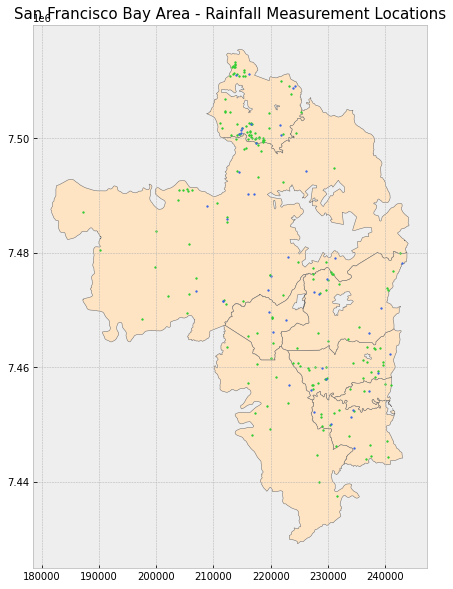

In [85]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# Stylize plots
plt.style.use('bmh')

# Plot data
counties.plot(ax = ax, color = 'bisque', edgecolor = 'dimgray')
rain_train_gdf.plot(ax = ax, marker = 'o', color = 'limegreen', markersize = 3)
rain_test_gdf.plot(ax = ax, marker = 'o', color = 'royalblue', markersize = 3)
# Set title
ax.set_title('San Francisco Bay Area - Rainfall Measurement Locations', fontdict = {'fontsize': '15', 'fontweight' : '3'})

In [86]:
# Extend extent of counties feature by using buffer
counties_buffer = counties.buffer(100000)

# Get extent of buffered input feature
min_x_cty_tp, min_y_cty_tp, max_x_cty_tp, max_y_cty_tp = counties_buffer.total_bounds

# Use extent to create dummy points and add them to list of coordinates
coords_tp = coords_rain_train + [[min_x_cty_tp, min_y_cty_tp], [max_x_cty_tp, min_y_cty_tp],
                                 [max_x_cty_tp, max_y_cty_tp], [min_x_cty_tp, max_y_cty_tp]]

# Compute Voronoi diagram
tp = Voronoi(coords_tp)

# Create empty list of hold Voronoi polygons
tp_poly_list = []

# Create a polygon for each region
# 'regions' attribute provides a list of indices of the vertices (in the 'vertices' attribute) that make up the region
# Source: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Voronoi.html
for region in tp.regions:

    # Ignore region if -1 is in the list (based on documentation)
    if -1 in region:

        # Return to top of loop
        continue

    # Otherwise, pass
    else:
        pass

    # Check that region list has values in it
    if len(region) != 0:

        # Create a polygon by using the region list to call the correct elements in the 'vertices' attribute
        tp_poly_region = Polygon(list(tp.vertices[region]))

        # Append polygon to list
        tp_poly_list.append(tp_poly_region)

    # If no values, return to top of loop
    else:
        continue

# Create GeoDataFrame from list of polygon regions
tp_polys = gpd.GeoDataFrame(tp_poly_list, columns = ['geometry'], crs = proj)

# Clip polygon regions to the counties boundary
tp_polys_clipped = gpd.clip(tp_polys, counties_dissolved)

In [87]:
# If rainfall point within the polygon, assign that rainfall value to the polygon
tp_polys_clipped_values = gpd.sjoin(rain_train_gdf, tp_polys_clipped, how = "right", predicate = 'within')

# Drop un-needed column
tp_polys_clipped_values = tp_polys_clipped_values.drop("index_left", axis = 1)

# Rename column
tp_polys_clipped_values = tp_polys_clipped_values.rename(columns = {"Actual_Value": "VALUE_Thiessen"})

# Display head of attribute table
print("Attribute Table: Thiessen Polygon Interpolated Values")
display(tp_polys_clipped_values.head())

Attribute Table: Thiessen Polygon Interpolated Values


,VALUE_Thiessen,geometry
1,16.7,"POLYGON ((230990.903 7439915.636, 231109.449 7..."
61,48.9,"POLYGON ((231109.191 7442630.806, 221064.826 7..."
60,19.5,"POLYGON ((231109.191 7442630.806, 229156.491 7..."
59,59.2,"POLYGON ((225807.680 7447680.671, 229661.352 7..."
64,48.5,"POLYGON ((229515.541 7450580.638, 229661.352 7..."


<AxesSubplot:>

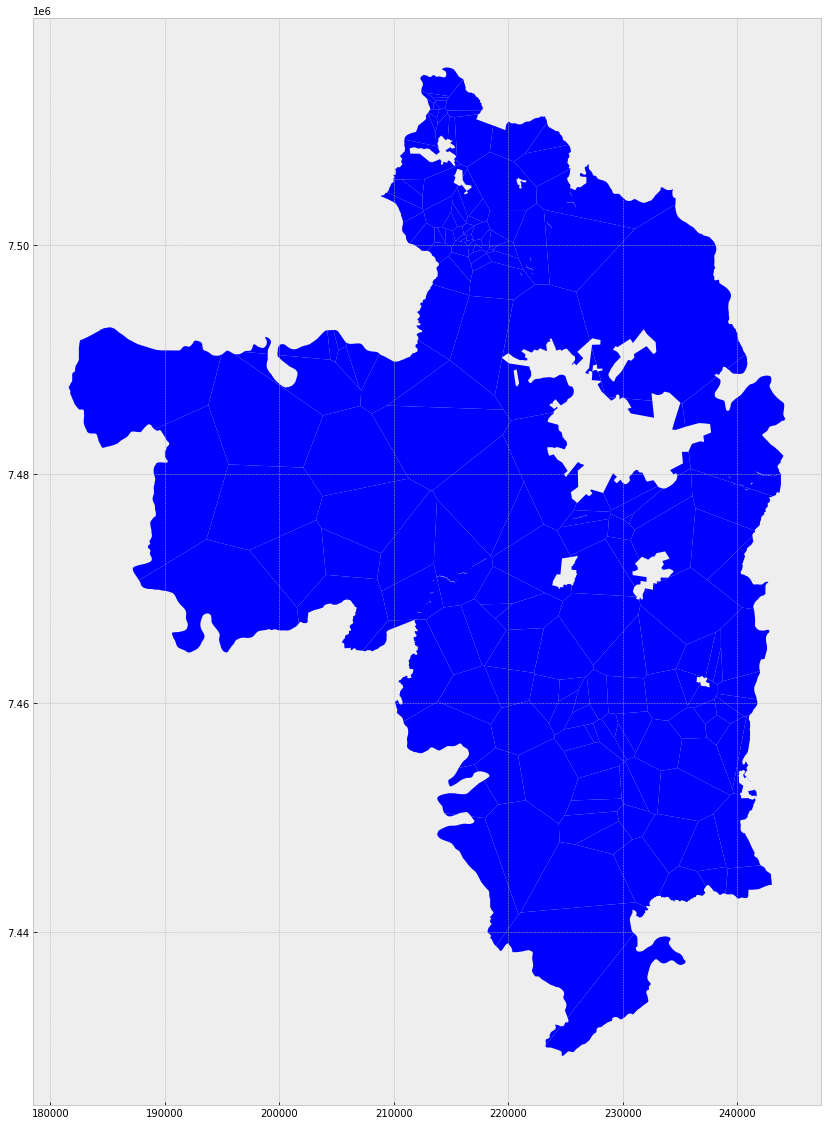

In [88]:
fig, ax = plt.subplots(1, 1, figsize = (20, 20))
tp_polys_clipped_values.plot(ax = ax)

In [89]:
# If test point is within a polygon, assign that polygon's value to the test point
rain_test_pred_tp = gpd.sjoin(rain_test_gdf, tp_polys_clipped_values, how = "left", predicate = 'within')

# Drop un-needed column
rain_test_pred_tp = rain_test_pred_tp.drop("index_right", axis = 1)

# Rename column
rain_test_pred_tp = rain_test_pred_tp.rename(columns = {"Actual_Value": "VALUE_Actual", "VALUE_Thiessen": "VALUE_Predict"})

# Generate out-of-sample R^2
out_r_squared_tp = r2_score(rain_test_pred_tp.VALUE_Actual, rain_test_pred_tp.VALUE_Predict)
print("Thiessen polygon out-of-sample r-squared: {}".format(round(out_r_squared_tp, 2)))

# Display attribute table
print("\nAttribute Table: Testing Dataset Interpolated Values - Thiessen Polygon Method")
display(rain_test_pred_tp.head(2))

Thiessen polygon out-of-sample r-squared: -0.05

Attribute Table: Testing Dataset Interpolated Values - Thiessen Polygon Method


,geometry,VALUE_Actual,VALUE_Predict
0,POINT (214547.757 7494154.735),8.3,6.1
1,POINT (211741.829 7471655.416),20.0,12.6


Text(0.5, 1.0, 'San Francisco Bay Area - Rainfall Measurement Locations & Thiessen Polygons')

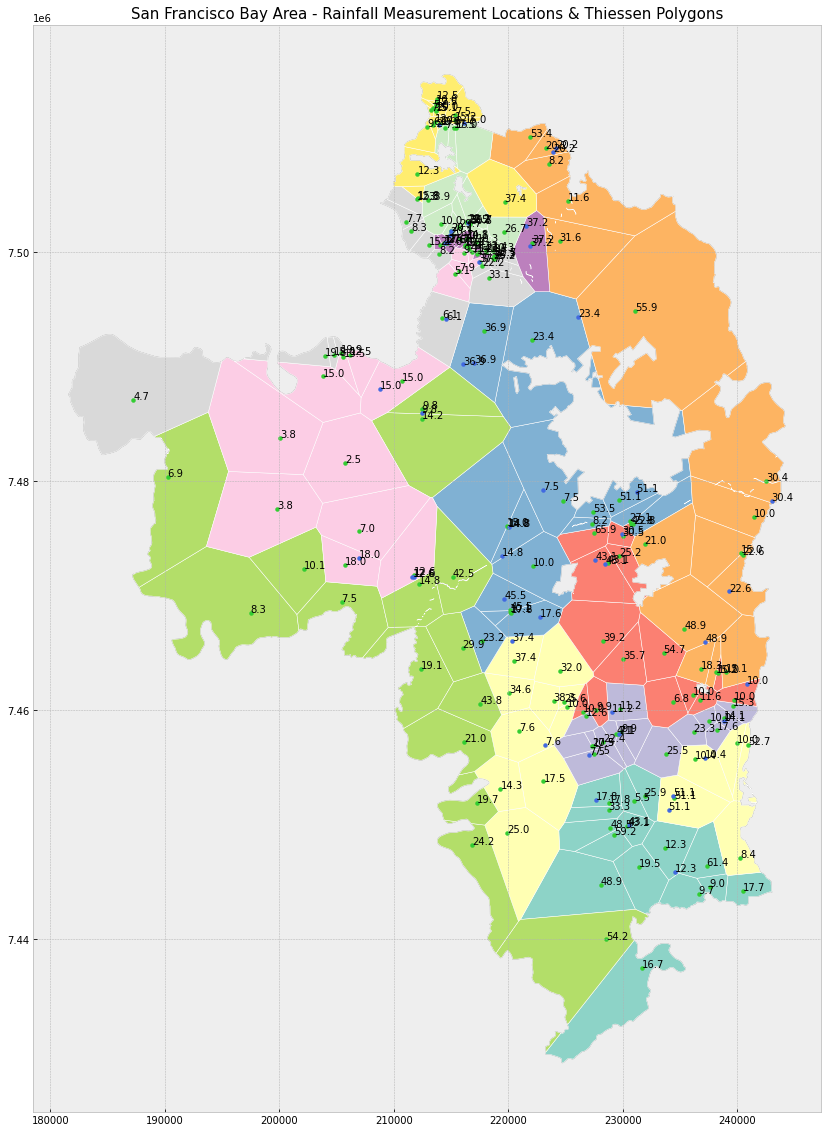

In [90]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (20, 20))

# Stylize plots
plt.style.use('bmh')

# Plot data
counties_dissolved.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
tp_polys_clipped.plot(ax = ax, cmap = 'Set3', edgecolor = 'white', linewidth = 0.5)
rain_train_gdf.plot(ax = ax, marker = 'o', color = 'limegreen', markersize = 15)
rain_test_pred_tp.plot(ax = ax, marker = 'o', color = 'royalblue', markersize = 15)

# Iterate through each rainfall train point to add a label with its value to the plot
for index, row in rain_train_gdf.iterrows():
    plt.annotate(row.Actual_Value, (row.geometry.x, row.geometry.y))

# Iterate through each rainfall test point to add a label with its value to the plot
for index, row in rain_test_pred_tp.iterrows():
    plt.annotate(row.VALUE_Predict, (row.geometry.x, row.geometry.y))

# Set title
ax.set_title('San Francisco Bay Area - Rainfall Measurement Locations & Thiessen Polygons', fontdict = {'fontsize': '15', 'fontweight' : '3'})

In [91]:
# Set index for feature of interest
feature_index_one = 5

# Get a Voronoi polygon for one feature
# 'point_region' attribute provides the index of the Voronoi region belonging to a specified point
# Can use the index to call the appropriate element in the 'regions' attribute
tp_poly_region_one = Polygon(tp.vertices[tp.regions[tp.point_region[feature_index_one]]])

# Create GeoDataFrame for polygon
tp_poly_region_one = gpd.GeoDataFrame([tp_poly_region_one], columns = ['geometry'], crs = proj)

# Clip polygon to county boundary
tp_poly_region_one = gpd.clip(tp_poly_region_one, counties_dissolved)

# Get the equivalent feature from the rainfall dataset
rain_one = rain_train_gdf.iloc[[feature_index_one]]

# Add the rainfall value to the polygon attribute table
tp_poly_region_one["VALUE_Predict"] = rain_one["Actual_Value"].values

# Display attribute table
print("Attribute Table: Thiessen Polygon Interpolated Value")
display(tp_poly_region_one)

Attribute Table: Thiessen Polygon Interpolated Value


,geometry,VALUE_Predict
0,"POLYGON ((213777.791 7477826.775, 213487.335 7...",12.6


Text(0.5, 1.0, 'San Francisco Bay Area - One Point and Thiessen Polygon')

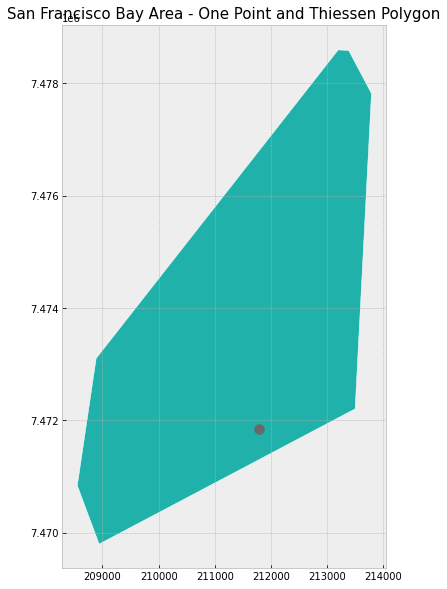

In [92]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# Stylize plots
plt.style.use('bmh')

# Plot data
tp_poly_region_one.plot(ax = ax, color = 'lightseagreen', edgecolor = 'white', linewidth = 0.5)
rain_one.plot(ax = ax, marker = 'o', color = 'dimgray', markersize = 100)

# Set title
ax.set_title('San Francisco Bay Area - One Point and Thiessen Polygon', fontdict = {'fontsize': '15', 'fontweight' : '3'})

In [93]:
# Set number of neighbors to look for
neighbors = 5

# Initialize KNN regressor
knn_regressor = KNeighborsRegressor(n_neighbors = neighbors, weights = "distance")

# Fit regressor to data
knn_regressor.fit(coords_rain_train, value_rain_train)

KNeighborsRegressor(weights='distance')

In [94]:
# Generate in-sample R^2
in_r_squared_knn = knn_regressor.score(coords_rain_train, value_rain_train)
print("KNN in-sample r-squared: {}".format(round(in_r_squared_knn, 2)))

KNN in-sample r-squared: 1.0


In [95]:
# Generate out-of-sample R^2
out_r_squared_knn = knn_regressor.score(coords_rain_test, value_rain_test)
print("KNN out-of-sample r-squared: {}".format(round(out_r_squared_knn, 2)))

# Predict values for testing dataset
coords_rain_test_predict_knn = knn_regressor.predict(coords_rain_test)

# Create dictionary holding the actual and predicted values
predict_dict_knn = {"Coordinate_Pair": coords_rain_test, "VALUE_Actual": value_rain_test, "VALUE_Predict": coords_rain_test_predict_knn}

# Create dataframe from dictionary
predict_df_knn = pd.DataFrame(predict_dict_knn)

# Display attribute table
print("\nAttribute Table: Testing Set Interpolated Values - KNN Method")
display(predict_df_knn.head(2))

KNN out-of-sample r-squared: 0.38

Attribute Table: Testing Set Interpolated Values - KNN Method


,Coordinate_Pair,VALUE_Actual,VALUE_Predict
0,"[214547.757, 7494154.735]",8.3,10.058259
1,"[211741.8294, 7471655.416]",20.0,14.219281


In [96]:
# Set projection to WGS 84 and reproject data
proj_wgs = 4326

counties_wgs = counties.to_crs(proj_wgs)
rainfall_wgs = rainfall.to_crs(proj_wgs)
rain_train_gdf_wgs = rain_train_gdf.to_crs(proj_wgs)
rain_test_gdf_wgs = rain_test_gdf.to_crs(proj_wgs)

# Get X and Y coordinates of rainfall points
x_rain_wgs = rainfall_wgs["geometry"].x
y_rain_wgs = rainfall_wgs["geometry"].y

# Create list of XY coordinate pairs
coords_rain_train_wgs = [list(xy) for xy in zip(rain_train_gdf_wgs["geometry"].x, rain_train_gdf_wgs["geometry"].y)]
coords_rain_test_wgs = [list(xy) for xy in zip(rain_test_gdf_wgs["geometry"].x, rain_test_gdf_wgs["geometry"].y)]

# Get minimum and maximum coordinate values of rainfall points
min_x_rain_wgs, min_y_rain_wgs, max_x_rain_wgs, max_y_rain_wgs = rain_train_gdf_wgs.total_bounds

In [97]:

# Create a 100 by 100 cell mesh grid
# Horizontal and vertical cell counts should be the same
XX_sk_krig, YY_sk_krig = np.mgrid[min_x_rain_wgs:max_x_rain_wgs:100j, min_y_rain_wgs:max_y_rain_wgs:100j]

# Create 2-D array of the coordinates (paired) of each cell in the mesh grid
positions_sk_krig = np.vstack([XX_sk_krig.ravel(), YY_sk_krig.ravel()]).T

# Generate Gaussian Process model (can change parameters as desired)
gp = GaussianProcessRegressor(n_restarts_optimizer = 10)

# Fit kernel density estimator to coordinates and values
gp.fit(coords_rain_train_wgs, value_rain_train)

# Evaluate the model on coordinate pairs
Z_sk_krig = gp.predict(positions_sk_krig)

# Reshape the data to fit mesh grid
Z_sk_krig = Z_sk_krig.reshape(XX_sk_krig.shape)

Next, we can calculate our r-squared statistics and predictions.

In [98]:
# Generate in-sample R^2
in_r_squared_sk_krig = gp.score(coords_rain_train_wgs, value_rain_train)
print("Scikit-Learn Kriging in-sample r-squared: {}".format(round(in_r_squared_sk_krig, 2)))

# Generate out-of-sample R^2
out_r_squared_sk_krig = gp.score(coords_rain_test_wgs, value_rain_test)
print("Scikit-Learn Kriging out-of-sample r-squared: {}".format(round(out_r_squared_sk_krig, 2)))

# Predict values for testing dataset
coords_rain_test_predict_sk_krig = gp.predict(coords_rain_test_wgs)

# Create dictionary holding the actual and predicted values
predict_dict_sk_krig = {"Coordinate_Pair": coords_rain_test_wgs, "VALUE_Actual": value_rain_test, "VALUE_Predict": coords_rain_test_predict_sk_krig}

# Create dataframe from dictionary
predict_df_sk_krig = pd.DataFrame(predict_dict_sk_krig)

# Display attribute table
print("\nAttribute Table: Testing Set Interpolated Values - Scikit-Learn Kriging Method")
display(predict_df_sk_krig.head(2))

Scikit-Learn Kriging in-sample r-squared: 0.31
Scikit-Learn Kriging out-of-sample r-squared: 0.25

Attribute Table: Testing Set Interpolated Values - Scikit-Learn Kriging Method


,Coordinate_Pair,VALUE_Actual,VALUE_Predict
0,"[-47.777230037967925, -22.635595731374075]",8.3,15.385041
1,"[-47.808651349734426, -22.838128866671276]",20.0,18.275111


In [99]:
# Flip array vertically and rotate 270 degrees
Z_sk_krig = np.rot90(np.flip(Z_sk_krig, 0), 3)

# Export raster
export_kde_raster(Z = Z_sk_krig, XX = XX_sk_krig, YY = YY_sk_krig,
                  min_x = min_x_rain_wgs, max_x = max_x_rain_wgs, min_y = min_y_rain_wgs, max_y = max_y_rain_wgs,
                  proj = proj_wgs, filename = "e_bay-area-rain_sk_kriging.tif")

In [100]:
# Open raster
raster_sk = rasterio.open("e_bay-area-rain_sk_kriging.tif")

# Mask raster to counties shape
out_image_sk, out_transform_sk = rasterio.mask.mask(raster_sk, counties_wgs.geometry.values, crop = True)

# Stylize plots
plt.style.use('bmh')

### Method 2- Using `scikit-learn`

Kriging can be performed using [Gaussian processes from the `scikit-learn` module](https://scikit-learn.org/stable/modules/gaussian_process.html) (Gaussian processes is essentially equivalent to kriging). Various kernels for Gaussian processes can be specified. We will continue to use the training and testing datasets created from our KNN analysis.

In [101]:
# Create a 100 by 100 cell mesh grid
# Horizontal and vertical cell counts should be the same
XX_sk_krig, YY_sk_krig = np.mgrid[min_x_rain_wgs:max_x_rain_wgs:100j, min_y_rain_wgs:max_y_rain_wgs:100j]

# Create 2-D array of the coordinates (paired) of each cell in the mesh grid
positions_sk_krig = np.vstack([XX_sk_krig.ravel(), YY_sk_krig.ravel()]).T

# Generate Gaussian Process model (can change parameters as desired)
gp = GaussianProcessRegressor(n_restarts_optimizer = 10)

# Fit kernel density estimator to coordinates and values
gp.fit(coords_rain_train_wgs, value_rain_train)

# Evaluate the model on coordinate pairs
Z_sk_krig = gp.predict(positions_sk_krig)

# Reshape the data to fit mesh grid
Z_sk_krig = Z_sk_krig.reshape(XX_sk_krig.shape)

In [102]:
# Generate in-sample R^2
in_r_squared_sk_krig = gp.score(coords_rain_train_wgs, value_rain_train)
print("Scikit-Learn Kriging in-sample r-squared: {}".format(round(in_r_squared_sk_krig, 2)))

# Generate out-of-sample R^2
out_r_squared_sk_krig = gp.score(coords_rain_test_wgs, value_rain_test)
print("Scikit-Learn Kriging out-of-sample r-squared: {}".format(round(out_r_squared_sk_krig, 2)))

# Predict values for testing dataset
coords_rain_test_predict_sk_krig = gp.predict(coords_rain_test_wgs)

# Create dictionary holding the actual and predicted values
predict_dict_sk_krig = {"Coordinate_Pair": coords_rain_test_wgs, "VALUE_Actual": value_rain_test, "VALUE_Predict": coords_rain_test_predict_sk_krig}

# Create dataframe from dictionary
predict_df_sk_krig = pd.DataFrame(predict_dict_sk_krig)

# Display attribute table
print("\nAttribute Table: Testing Set Interpolated Values - Scikit-Learn Kriging Method")
display(predict_df_sk_krig.head(2))

Scikit-Learn Kriging in-sample r-squared: 0.31
Scikit-Learn Kriging out-of-sample r-squared: 0.25

Attribute Table: Testing Set Interpolated Values - Scikit-Learn Kriging Method


,Coordinate_Pair,VALUE_Actual,VALUE_Predict
0,"[-47.777230037967925, -22.635595731374075]",8.3,15.385041
1,"[-47.808651349734426, -22.838128866671276]",20.0,18.275111


Model seems like a good fit! Let's export the raster.

In [103]:
# Flip array vertically and rotate 270 degrees
Z_sk_krig = np.rot90(np.flip(Z_sk_krig, 0), 3)

# Export raster
export_kde_raster(Z = Z_sk_krig, XX = XX_sk_krig, YY = YY_sk_krig,
                  min_x = min_x_rain_wgs, max_x = max_x_rain_wgs, min_y = min_y_rain_wgs, max_y = max_y_rain_wgs,
                  proj = proj_wgs, filename = "e_bay-area-rain_sk_kriging-method-2.tif")

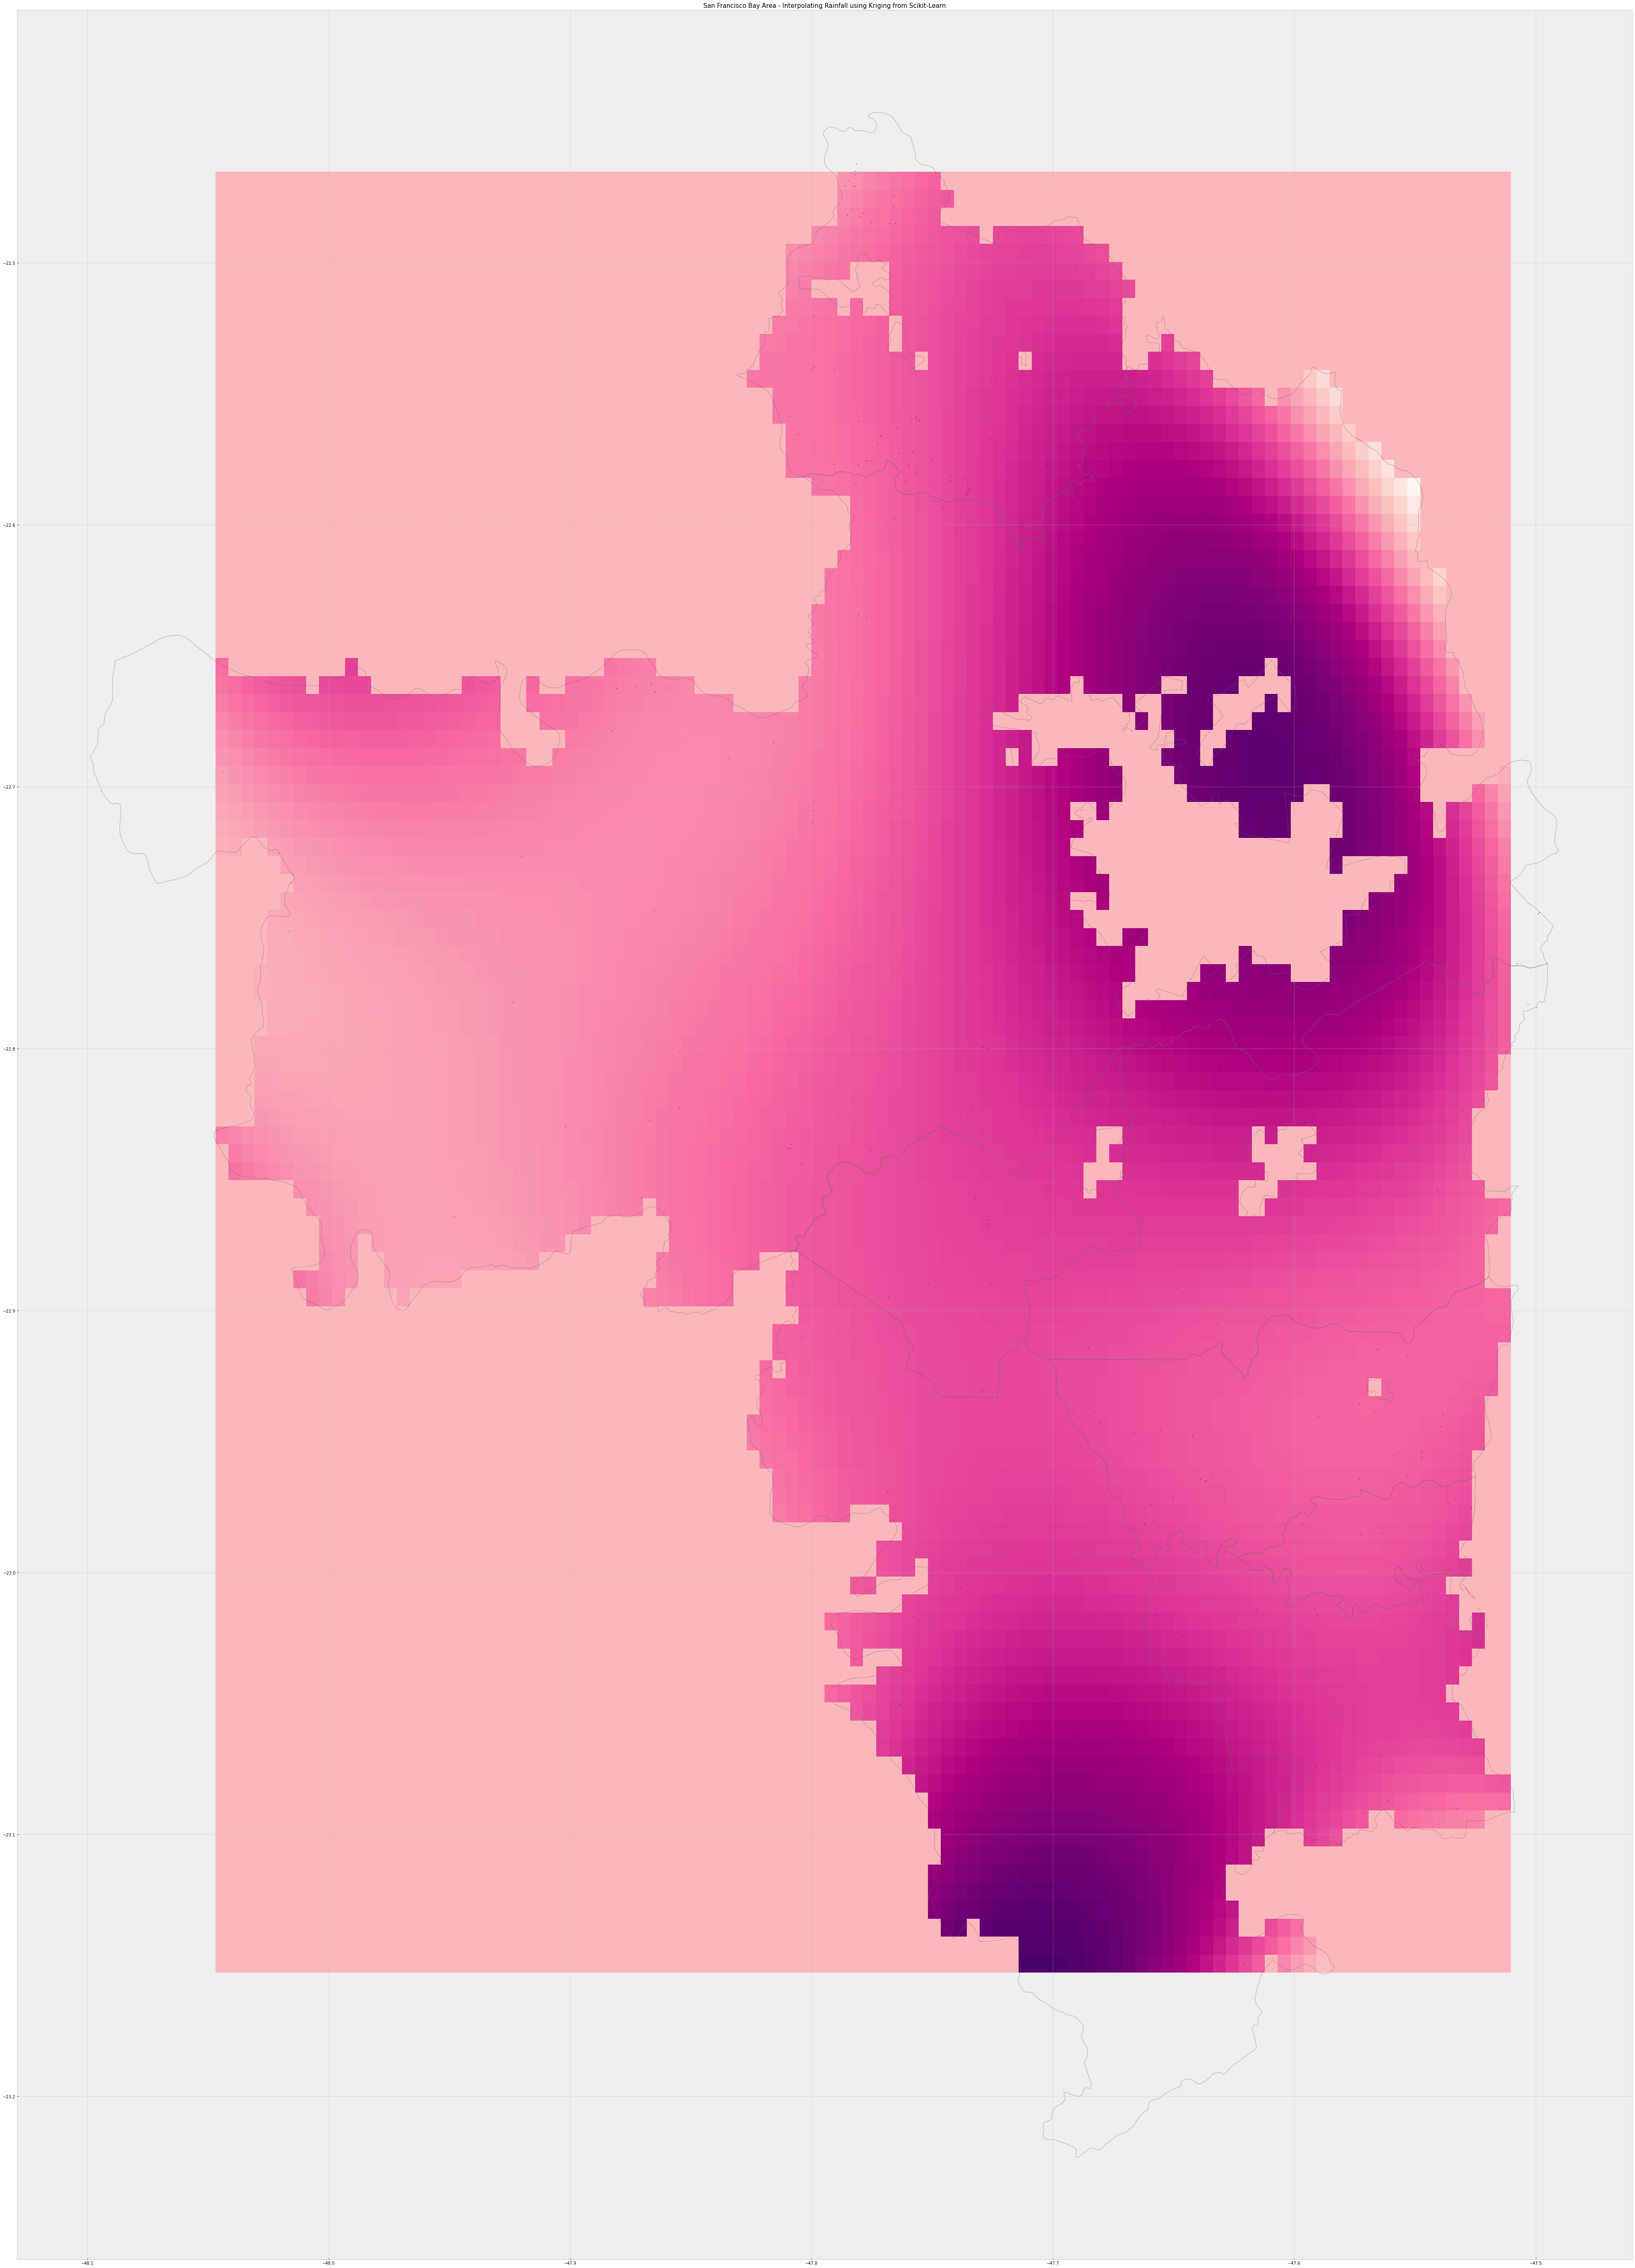

In [104]:
# Open raster
raster_sk = rasterio.open("e_bay-area-rain_sk_kriging-method-2.tif")

# Mask raster to counties shape
out_image_sk, out_transform_sk = rasterio.mask.mask(raster_sk, counties_wgs.geometry.values, crop = True)

# Stylize plots
plt.style.use('bmh')

# Plot data
fig, ax = plt.subplots(1, figsize = (100, 100))
show(out_image_sk, ax = ax, transform = out_transform_sk, cmap = "RdPu")
ax.plot(x_rain_wgs, y_rain_wgs, 'k.', markersize = 2, alpha = 0.5)
counties_wgs.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
plt.gca().invert_yaxis()

# Set title
ax.set_title('San Francisco Bay Area - Interpolating Rainfall using Kriging from Scikit-Learn', fontdict = {'fontsize': '15', 'fontweight' : '3'})

# Display plot
plt.show()